In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
tf.set_random_seed(777)

# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) 

# Reverse
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

# Loading Data
Monthly_file_name = 'ic7.csv' 
encoding = 'euc-kr' 
names = ['Holiday','Date','Japan','China','Northeast Asia','Southeast Asia','Americas','Europe','Oceania','Middle East','Others','Total']
raw_dataframe = pd.read_csv(Monthly_file_name, names=names, encoding=encoding) 
raw_dataframe.info() 
Monthly_info = raw_dataframe.values[1:].astype(np.float) 

# Hyper parameter
input_data_column_cnt = 12  
output_data_column_cnt = 1

seq_length = 12       
rnn_cell_hidden_dim = 200  
forget_bias = 1.0         
num_stacked_layers = 1     
keep_prob = 0.9           

epoch_num =  630   
learning_rate = 0.01     

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 12 columns):
Holiday           193 non-null object
Date              193 non-null object
Japan             193 non-null object
China             193 non-null object
Northeast Asia    193 non-null object
Southeast Asia    193 non-null object
Americas          193 non-null object
Europe            193 non-null object
Oceania           193 non-null object
Middle East       193 non-null object
Others            193 non-null object
Total             193 non-null object
dtypes: object(12)
memory usage: 18.2+ KB


In [2]:
# Data preprocessing
holiday = Monthly_info[:,:1]
norm_holiday = min_max_scaling(holiday) 
print("holiday.shape: ", holiday.shape)
print("holiday[0]: ", holiday[0])
print("norm_holiday[0]: ", norm_holiday[0])
print("="*100) 

date = Monthly_info[:,1:2]
norm_date = min_max_scaling(date) 
print("date.shape: ", date.shape)
print("date[0]: ", date[0])
print("norm_date[0]: ", norm_date[0])
print("="*100) 

continent = Monthly_info[:,2:-1]
norm_continent = min_max_scaling(continent) 
print("continent.shape: ", continent.shape)
print("continent[0]: ", continent[0])
print("norm_continent[0]: ", norm_continent[0])
print("="*100) 

total = Monthly_info[:,-1:]
norm_total = min_max_scaling(total) 
print("total.shape: ", total.shape)
print("total[0]: ", total[0])
print("norm_total[0]: ", norm_total[0])
print("="*100) 

x = np.concatenate((norm_holiday, norm_date, norm_continent, norm_total), axis=1) 
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    
print("x[-1]: ", x[-1]) 
print("="*100) 

y = x[:, [-1]] 
print("y[0]: ",y[0])    
print("y[-1]: ",y[-1])  

holiday.shape:  (192, 1)
holiday[0]:  [10.]
norm_holiday[0]:  [0.28571428]
date.shape:  (192, 1)
date[0]:  [31.]
norm_date[0]:  [0.99999997]
continent.shape:  (192, 9)
continent[0]:  [533145. 306714. 175793. 382164. 212157. 126121. 130973.   2473.  19981.]
norm_continent[0]:  [0.28960486 0.16645719 0.09525397 0.20749173 0.11503104 0.06823916
 0.07087799 0.00099146 0.01051343]
total.shape:  (192, 1)
total[0]:  [1889521.]
norm_total[0]:  [0.17660126]
x.shape:  (192, 12)
x[0]:  [2.85714282e-01 9.99999967e-01 2.89604856e-01 1.66457188e-01
 9.52539709e-02 2.07491726e-01 1.15031041e-01 6.82391588e-02
 7.08779868e-02 9.91464055e-04 1.05134348e-02 1.76601256e-01]
x[-1]:  [0.42857142 0.99999997 0.65687023 0.53342289 0.3512551  0.99898841
 0.2338811  0.21985212 0.13540962 0.03398552 0.02347698 0.95185266]
y[0]:  [0.17660126]
y[-1]:  [0.95185266]


In [3]:
dataX = [] 
dataY = [] 

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] 
    if i is 0:
        print(_x, "->", _y) 
    dataX.append(_x) 
    dataY.append(_y) 

train_size = int(len(dataY) * 0.6)
test_size = len(dataY) - train_size

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])    

X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
Y = tf.placeholder(tf.float32, [None, 1])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])

def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

loss = tf.reduce_sum(tf.square(hypothesis - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))
mape = tf.reduce_mean(tf.abs((predictions-targets))/targets)*100
mse=tf.reduce_mean(tf.square(predictions - targets))

[[2.85714282e-01 9.99999967e-01 2.89604856e-01 1.66457188e-01
  9.52539709e-02 2.07491726e-01 1.15031041e-01 6.82391588e-02
  7.08779868e-02 9.91464055e-04 1.05134348e-02 1.76601256e-01]
 [0.00000000e+00 0.00000000e+00 2.74195013e-01 1.55546733e-01
  9.03548441e-02 1.73633474e-01 8.59865285e-02 5.86693280e-02
  5.83935889e-02 8.32655769e-04 8.61317402e-03 1.34217648e-01]
 [2.85714282e-01 9.99999967e-01 2.77107405e-01 1.40531736e-01
  6.36837540e-02 1.45876287e-01 9.06920397e-02 6.16442640e-02
  4.76016958e-02 5.89548566e-04 6.77926464e-03 1.08508578e-01]
 [0.00000000e+00 6.66666644e-01 2.01365099e-01 8.07643465e-02
  2.93294973e-02 7.72983012e-02 7.45811567e-02 5.12178474e-02
  4.01806716e-02 0.00000000e+00 4.99321530e-03 1.00102977e-02]
 [4.28571422e-01 9.99999967e-01 1.80772776e-01 4.82086480e-02
  2.60516290e-02 7.95123715e-02 9.09188310e-02 5.80504108e-02
  4.11438547e-02 1.15788644e-03 5.98848640e-03 0.00000000e+00]
 [2.85714282e-01 6.66666644e-01 1.92417992e-01 7.45991043e-02
  4

In [4]:
train_error_summary = [] 
test_error_summary = []  
test_error_summary2 = []
test_predict = ''       

sess = tf.Session()
sess.run(tf.global_variables_initializer())


start_time = datetime.datetime.now() 
print('Start Learning!')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 10 == 0) or (epoch == epoch_num-1): 
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error) 
        train_error2 = sess.run(mape, feed_dict={targets: trainY, predictions: train_predict})
        train_error3 = sess.run(mse, feed_dict={targets: trainY, predictions: train_predict})
       
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        test_error2 = sess.run(mape, feed_dict={targets: testY, predictions: test_predict})
        test_error3 = sess.run(mse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary2.append(test_error2)
        
        print("epoch: {}, RMSE(train): {}, RMSE(test): {}".format(epoch+1, train_error, test_error))
        print("epoch: {}, MAPE(train): {}, MAPE(test): {}".format(epoch+1, train_error2, test_error2))
        print("epoch: {}, MSE(train): {}, MSE(test): {}".format(epoch+1, train_error3, test_error3))
end_time = datetime.datetime.now() 
elapsed_time = end_time - start_time 
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

Start Learning!
epoch: 10, RMSE(train): 0.10778091847896576, RMSE(test): 0.28581470251083374
epoch: 10, MAPE(train): 38.50798797607422, MAPE(test): 32.700626373291016
epoch: 10, MSE(train): 0.011616726405918598, MSE(test): 0.08169005066156387
epoch: 20, RMSE(train): 0.08770421892404556, RMSE(test): 0.30386191606521606
epoch: 20, MAPE(train): 30.230724334716797, MAPE(test): 36.373023986816406
epoch: 20, MSE(train): 0.007692030631005764, MSE(test): 0.09233205765485764
epoch: 30, RMSE(train): 0.08112363517284393, RMSE(test): 0.3873446583747864
epoch: 30, MAPE(train): 19.752702713012695, MAPE(test): 50.29042434692383
epoch: 30, MSE(train): 0.006581044755876064, MSE(test): 0.15003588795661926
epoch: 40, RMSE(train): 0.06964187324047089, RMSE(test): 0.3130124807357788
epoch: 40, MAPE(train): 22.61239242553711, MAPE(test): 37.882415771484375
epoch: 40, MSE(train): 0.004849990364164114, MSE(test): 0.09797680377960205
epoch: 50, RMSE(train): 0.06311549991369247, RMSE(test): 0.3211643099784851
e

epoch: 370, RMSE(train): 0.037992607802152634, RMSE(test): 0.18718229234218597
epoch: 370, MAPE(train): 10.855536460876465, MAPE(test): 21.960132598876953
epoch: 370, MSE(train): 0.001443438115529716, MSE(test): 0.03503721207380295
epoch: 380, RMSE(train): 0.0351843424141407, RMSE(test): 0.17327478528022766
epoch: 380, MAPE(train): 9.212689399719238, MAPE(test): 19.267473220825195
epoch: 380, MSE(train): 0.0012379378313198686, MSE(test): 0.030024150386452675
epoch: 390, RMSE(train): 0.0385938324034214, RMSE(test): 0.12142247706651688
epoch: 390, MAPE(train): 10.992314338684082, MAPE(test): 12.895539283752441
epoch: 390, MSE(train): 0.0014894838677719235, MSE(test): 0.014743417501449585
epoch: 400, RMSE(train): 0.032917991280555725, RMSE(test): 0.1196308359503746
epoch: 400, MAPE(train): 9.029640197753906, MAPE(test): 12.907332420349121
epoch: 400, MSE(train): 0.0010835941648110747, MSE(test): 0.014311537146568298
epoch: 410, RMSE(train): 0.030183961614966393, RMSE(test): 0.110868260264

input_data_column_cnt: 12,output_data_column_cnt: 1,seq_length: 12,rnn_cell_hidden_dim: 200,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 0.9,epoch_num: 630,learning_rate: 0.01,train_error: 0.017396053,test_error: 0.047278523,min_train_error: 0.017396053
,min_test_error: 0.047278523


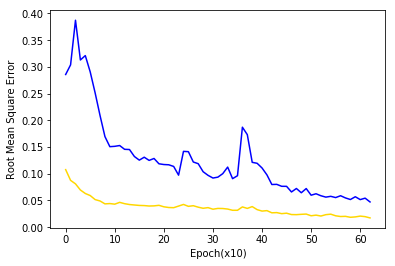

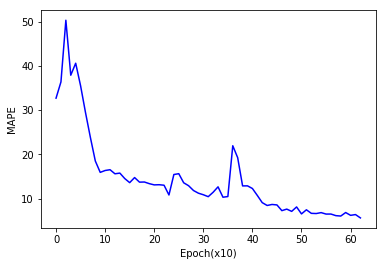

<Figure size 432x288 with 0 Axes>

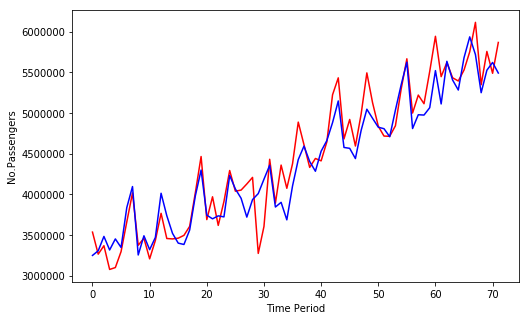

In [5]:
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_train_error:', np.min(train_error_summary))
print(',min_test_error:', np.min(test_error_summary))

plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x10)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(test_error_summary2, 'b')
plt.xlabel('Epoch(x10)')
plt.ylabel('MAPE')

plt.figure(3)
plt.figure(figsize=(8,5))
test_Y = reverse_min_max_scaling(total,testY)
test_predict1 = reverse_min_max_scaling(total,test_predict)
plt.plot(test_Y, 'r')
plt.plot(test_predict1, 'b')
plt.xlabel('Time Period')
plt.ylabel('No.Passengers')
plt.show()

In [6]:
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(total,test_predict) 
print("Next month number of passengers are", int(test_predict[0])) 

recent_data.shape: (1, 12, 12)
recent_data: [[[0.14285714 0.99999997 0.65664779 0.50510117 0.35753999 1.
   0.23752009 0.22327575 0.18211612 0.04133366 0.02470665 0.96658542]
  [0.28571428 0.         0.61159681 0.50113042 0.3195549  0.88225997
   0.21285749 0.20847449 0.16144059 0.04006972 0.02114652 0.86990298]
  [0.28571428 0.99999997 0.65192433 0.52526384 0.31507509 0.89824577
   0.23255135 0.22792089 0.13773791 0.04183293 0.02240992 0.90375348]
  [0.14285714 0.66666664 0.58587368 0.52783577 0.3291938  0.83637906
   0.23161971 0.24862688 0.13035658 0.04351021 0.01775281 0.86725662]
  [0.28571428 0.99999997 0.58030125 0.54355943 0.32018089 0.7697715
   0.2548601  0.27444737 0.1266991  0.04329266 0.01639967 0.85950062]
  [0.42857142 0.66666664 0.58470165 0.54326139 0.32428217 0.7906798
   0.26596689 0.29859275 0.13412067 0.04327471 0.01785832 0.88574992]
  [0.14285714 0.99999997 0.59103005 0.57475873 0.32639454 0.82173824
   0.27782531 0.32493535 0.13849605 0.04891404 0.0204259  0.929